[<img src="https://github.com/lourencocavalcante/LogosINPE/blob/main/logoinpe.png?raw=true" width = 500 align="left">](https://www.gov.br/inpe/pt-br)

[<img src="https://github.com/lourencocavalcante/LogosINPE/blob/main/LogoCAP.png?raw=true" width = 300 align="right">](http://www.inpe.br/posgraduacao/cap/)

# **CAP-340 Problemas Inversos**
## **Esta atividade trata da identificação da condição inicial no problema de condução de calor em uma barra metálica usando um algoritmo genético (AG), em que para formulação do problema inverso, o problema é tratado como um problema de otimização**

**Docente:** *Haroldo Fraga de Campos Velho*

**Discente:** *Lourenço José Cavalcante Neto*

---


<img src="https://github.com/lourencocavalcante/CAP-340-Problemas-Inversos/blob/main/Exerc_parte1.PNG?raw=true" width = 800 align="center">
<img src="https://github.com/lourencocavalcante/CAP-340-Problemas-Inversos/blob/main/Exerc_parte2.PNG?raw=true" width = 800 align="center">

### O objetivo é calcular a evolução da temperatura ao longo da barra e compará-la com medições obtidas em sensores ao longo da barra. As medições são obtidas adicionando ruído uniforme às temperaturas simuladas

## 1. Resolver o problema direto da equação do calor

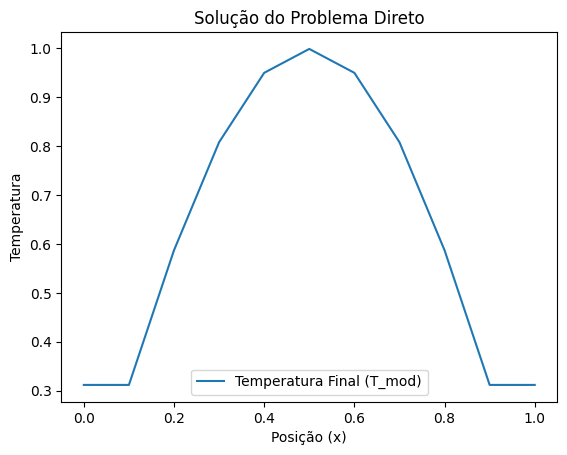

In [24]:
# Título do notebook: Item 1 - Resolução do Problema Direto da Equação do Calor

# Parâmetros físicos
alpha = 0.01  # Difusividade térmica
Lx = 1.0      # Comprimento da barra
dx = 0.1      # Passo espacial
tau = 0.01    # Tempo total da simulação

# Função para resolver a equação do calor usando diferenças finitas explícitas
def solve_heat_equation(f):
    """
    Resolve numericamente a equação do calor ao longo do tempo.
    Retorna a temperatura final T no tempo t = tau.
    """
    nx = len(f)                # Número de pontos espaciais
    dx = Lx / (nx - 1)         # Reajuste do passo espacial
    dt = 1e-4                  # Passo temporal para estabilidade
    nt = int(tau / dt)         # Número de passos no tempo
    r = alpha * dt / dx**2     # Número de Courant
    
    # Inicialização das temperaturas
    T = np.zeros((nt, nx))     # Matriz para armazenar as temperaturas no tempo
    T[0, :] = f                # Define a condição inicial
    
    # Método explícito: atualiza temperatura no tempo
    for n in range(0, nt - 1):
        T[n + 1, 1:-1] = T[n, 1:-1] + r * (T[n, :-2] - 2 * T[n, 1:-1] + T[n, 2:])
        
        T[n + 1, 0] = T[n + 1, 1]   # Condição de contorno esquerda
        T[n + 1, -1] = T[n + 1, -2] # Condição de contorno direita

        # Para evitar os valores são iguais nas extremidades, podemos usar:
        #T[n + 1, 0] = 0   # Define temperatura fixa na extremidade esquerda
        #T[n + 1, -1] = 0  # Define temperatura fixa na extremidade direita
    
    return T[-1, :]  # Retorna T final no tempo tau

# Teste: Condição inicial sinusoidal
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(0, Lx, int(Lx / dx) + 1)
initial_condition = np.sin(np.pi * x)

# Solução do problema direto
final_temperature = solve_heat_equation(initial_condition)

# Gráfico da solução
plt.plot(x, final_temperature, label="Temperatura Final (T_mod)")
plt.xlabel("Posição (x)")
plt.ylabel("Temperatura")
plt.title("Solução do Problema Direto")
plt.legend()
plt.show()


Por que os valores são iguais nas extremidades?
* Nas condições implementadas, as extremidades x=0 e x=Lx **não podem trocar calor** com o ambiente externo.
* Isso significa que a temperatura em T(0) e T(Lx) é ajustada para ser **igual ao ponto vizinho mais próximo**.
* Essa condição força os valores em x=0 e x=Lx a se **equalizarem** ao longo do tempo.

Para evitar isso, podemos usar:
po.


## 2. Construir o conjunto de soluções candidatas

In [25]:
population_size = 200  # Número de indivíduos na população

def initialize_population(size, length):
    """
    Gera uma população inicial de soluções candidatas aleatórias no intervalo [-1, 1].
    """
    return [np.random.uniform(-1, 1, length) for _ in range(size)]

# Teste da função: Geração da população inicial
length = len(x)  # Número de pontos na barra
population = initialize_population(population_size, length)

# Visualizar as primeiras 5 soluções candidatas
print("Primeiras 5 soluções candidatas, das 200:")
for i in range(5):
    print(population[i])


Primeiras 5 soluções candidatas, das 200:
[-0.41531674 -0.87747087 -0.66209945  0.51239344  0.99570068  0.01417181
  0.16869519 -0.64110283 -0.23661116  0.72135194 -0.12329983]
[ 0.45131302  0.66009653 -0.94060784  0.63899383 -0.10856917 -0.07596436
  0.07875693  0.86679303 -0.83648009 -0.248547   -0.77438094]
[-0.92417101  0.40412539  0.61395404 -0.80998943 -0.1706652  -0.57900212
  0.60933967  0.17568283 -0.76755977  0.62775796 -0.72092785]
[ 0.07585952  0.28581021  0.9470367   0.87016877 -0.89604314 -0.14547516
  0.73028831 -0.6533349   0.27142679 -0.22972257 -0.899672  ]
[-0.28152934  0.19205584  0.29509673  0.36165691  0.30625338 -0.39525014
 -0.98128505 -0.68482756  0.77641417 -0.65547411  0.4441591 ]


## 3. Implementar o elitismo no Algoritmo Genético

In [26]:
elite_fraction = 0.3  # Proporção de elitismo (30%)
elite_size = int(elite_fraction * population_size)

def preserve_elite(population, fitness, elite_fraction):
    """
    Seleciona os 30% melhores indivíduos da população (estratégia elitista).
    """
    elite_size = int(elite_fraction * len(population))
    sorted_indices = np.argsort(fitness)
    return [population[i] for i in sorted_indices[:elite_size]]

# Teste da função: preservar a elite
fitness = np.random.rand(population_size)  # Simula valores aleatórios de fitness
elite = preserve_elite(population, fitness, elite_fraction)

print(f"Selecionados {len(elite)} melhores indivíduos da elite. Vamos listar os 5 primeiros:\n")
print(elite[:5])


Selecionados 60 melhores indivíduos da elite. Vamos listar os 5 primeiros:

[array([ 0.34611756,  0.34108422, -0.75006485, -0.77667987, -0.12394648,
        0.24573001,  0.98525725,  0.77335832,  0.43726674,  0.13961597,
        0.84830361]), array([ 0.77831543,  0.0477897 ,  0.30313982,  0.73689738,  0.05407689,
       -0.53660139,  0.62872039, -0.90540181,  0.55569114,  0.72595076,
        0.73782033]), array([-0.53817794, -0.11872224,  0.56765519,  0.46230007,  0.51121885,
        0.30552102, -0.44451032,  0.43450128,  0.08961547, -0.56624466,
       -0.12748753]), array([ 0.83923624,  0.02867538, -0.98316374,  0.28602891, -0.12184711,
       -0.47688413, -0.09554813,  0.08711634,  0.66732653,  0.24160598,
        0.55914556]), array([ 0.46754848,  0.12050693,  0.41527509,  0.92262522, -0.5942698 ,
       -0.48386565, -0.08088938, -0.2327333 , -0.79025232, -0.77117342,
        0.36751721])]


## 4. Aplicar seleção, cruzamento e mutação

In [28]:
# Função de seleção via torneio
def select_parents(population, fitness):
    """
    Seleção via torneio: escolhe o melhor entre dois indivíduos aleatórios.
    """
    idx1, idx2 = np.random.choice(len(population), size=2, replace=False)
    return population[idx1] if fitness[idx1] < fitness[idx2] else population[idx2]

# Função de cruzamento
def crossover(parent1, parent2):
    """
    Cruzamento em um ponto aleatório para gerar um filho.
    """
    point = np.random.randint(1, len(parent1) - 1)
    return np.concatenate((parent1[:point], parent2[point:]))

# Função de mutação
def mutate(individual, rate):
    """
    Aplica mutação ao indivíduo com uma taxa específica.
    """
    for i in range(len(individual)):
        if np.random.rand() < rate:
            individual[i] += np.random.uniform(-0.1, 0.1)
    return individual

# Teste de seleção, cruzamento e mutação
parent1 = elite[0]
parent2 = elite[1]
child = crossover(parent1, parent2)
mutated_child = mutate(child, rate=0.05)

print("Pai 1:\n", parent1, "\n")
print("Pai 2:\n", parent2, "\n")
print("Filho gerado (crossover):\n", child, "\n")
print("Filho após mutação:\n", mutated_child, "\n")


Pai 1:
 [ 0.34611756  0.34108422 -0.75006485 -0.77667987 -0.12394648  0.24573001
  0.98525725  0.77335832  0.43726674  0.13961597  0.84830361] 

Pai 2:
 [ 0.77831543  0.0477897   0.30313982  0.73689738  0.05407689 -0.53660139
  0.62872039 -0.90540181  0.55569114  0.72595076  0.73782033] 

Filho gerado (crossover):
 [ 0.34611756  0.34108422 -0.75006485  0.73689738  0.05407689 -0.53660139
  0.62872039 -0.90540181  0.55569114  0.72595076  0.73782033] 

Filho após mutação:
 [ 0.34611756  0.34108422 -0.75006485  0.73689738  0.05407689 -0.53660139
  0.62872039 -0.90540181  0.55569114  0.72595076  0.73782033] 



## Resultado Final: Aqui juntaremos todos os passos para o Algoritmo Genético (AG)

In [31]:
# Título do notebook: Resultado Final - Aplicação Completa do AG

# Parâmetros gerais
population_size = 200         # Tamanho da população inicial
generations = 100             # Número máximo de gerações
elite_fraction = 0.3          # Proporção da população preservada como elite
initial_mutation_rate = 0.05  # Taxa inicial de mutação
mutation_decay = 0.99         # Decaimento da mutação
convergence_threshold = 0.000001  # Critério de parada baseado na convergência
beta = 0.005                  # Parâmetro de regularização

# Importando as funções que já definimos anteriormente
def objective_function(f, T_obs, positions):
    T_mod = solve_heat_equation(f)
    misfit = np.sum((T_obs - T_mod)**2)  # Erro quadrático
    regularization = beta * np.sum(f**2)
    return misfit + regularization

def select_parents(population, fitness):
    idx1, idx2 = np.random.choice(len(population), size=2, replace=False)
    return population[idx1] if fitness[idx1] < fitness[idx2] else population[idx2]

def preserve_elite(population, fitness, elite_fraction):
    elite_size = int(elite_fraction * len(population))
    sorted_indices = np.argsort(fitness)
    return [population[i] for i in sorted_indices[:elite_size]]

def crossover(parent1, parent2):
    point = np.random.randint(1, len(parent1) - 1)
    return np.concatenate((parent1[:point], parent2[point:]))

def mutate(individual, rate):
    for i in range(len(individual)):
        if np.random.rand() < rate:
            individual[i] += np.random.uniform(-0.1, 0.1)
    return individual

def genetic_algorithm(T_obs, positions, length):
    """
    Implementa o AG para otimizar a condição inicial.
    """
    mutation_rate = initial_mutation_rate
    population = initialize_population(population_size, length)
    best_solutions = []

    for gen in range(generations):
        # Calcula o fitness para cada indivíduo
        fitness = [objective_function(ind, T_obs, positions) for ind in population]
        
        # Elitismo: preserva os melhores
        elite = preserve_elite(population, fitness, elite_fraction)
        new_population = elite[:]
        
        while len(new_population) < population_size:
            parent1 = select_parents(population, fitness)
            parent2 = select_parents(population, fitness)
            child = mutate(crossover(parent1, parent2), mutation_rate)
            new_population.append(child)
        
        population = new_population
        best_idx = np.argmin(fitness)
        best_solutions.append(fitness[best_idx])
        
        print(f"Geração {gen+1}, Melhor solução: {fitness[best_idx]:.6f}")
        
        # Critério de convergência
        if len(best_solutions) > 5 and max(best_solutions[-5:]) - min(best_solutions[-5:]) < convergence_threshold:
            print(f"Convergência atingida na geração {gen+1}")
            break
        
        mutation_rate *= mutation_decay  # Redução da mutação

    return population[np.argmin(fitness)], best_solutions

# Posições e condição inicial verdadeira
x = np.linspace(0, Lx, int(Lx / dx) + 1)     # Posições discretizadas
true_initial_condition = np.sin(np.pi * x)  # Condição inicial

# Gerar observações sintéticas com ruído
T_obs = solve_heat_equation(true_initial_condition) * (1 + 0.05 * np.random.uniform(-1, 1, len(x)))

# Executar o AG
best_solution, best_solutions = genetic_algorithm(T_obs, x, len(x))

Geração 1, Melhor solução: 2.125822
Geração 2, Melhor solução: 1.436635
Geração 3, Melhor solução: 1.072937
Geração 4, Melhor solução: 1.072937
Geração 5, Melhor solução: 0.931076
Geração 6, Melhor solução: 0.497438
Geração 7, Melhor solução: 0.497438
Geração 8, Melhor solução: 0.497438
Geração 9, Melhor solução: 0.339631
Geração 10, Melhor solução: 0.339631
Geração 11, Melhor solução: 0.311890
Geração 12, Melhor solução: 0.187173
Geração 13, Melhor solução: 0.187173
Geração 14, Melhor solução: 0.089469
Geração 15, Melhor solução: 0.076106
Geração 16, Melhor solução: 0.057955
Geração 17, Melhor solução: 0.057955
Geração 18, Melhor solução: 0.052962
Geração 19, Melhor solução: 0.052962
Geração 20, Melhor solução: 0.052962
Geração 21, Melhor solução: 0.047488
Geração 22, Melhor solução: 0.045066
Geração 23, Melhor solução: 0.038085
Geração 24, Melhor solução: 0.038085
Geração 25, Melhor solução: 0.037828
Geração 26, Melhor solução: 0.036525
Geração 27, Melhor solução: 0.035526
Geração 28

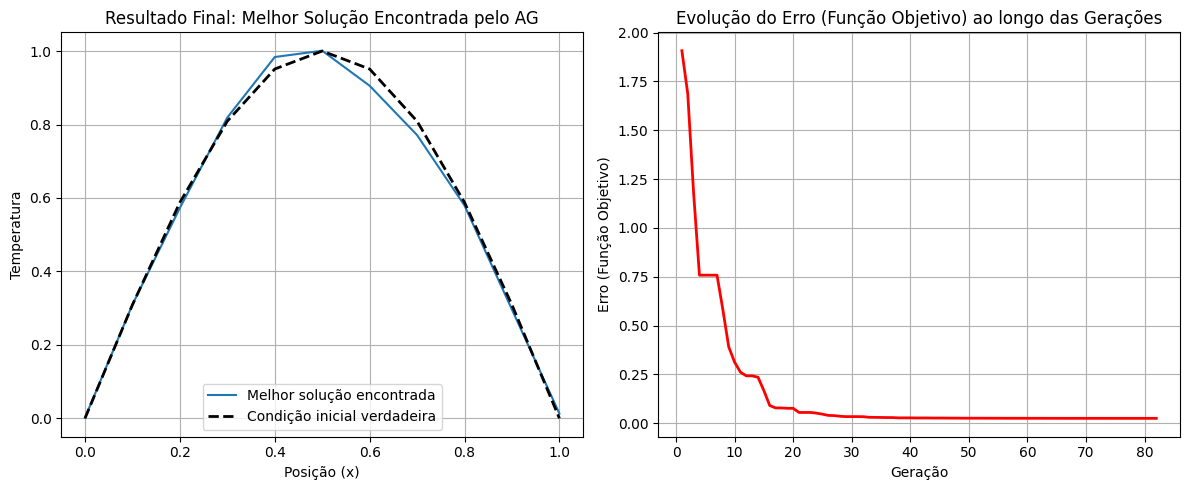

In [30]:
# Visualização dos Resultados
import matplotlib.pyplot as plt
# Configurar tamanho e layout para os subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Gráfico 1: Melhor solução encontrada vs condição inicial verdadeira
axes[0].plot(x, best_solution, label="Melhor solução encontrada")
axes[0].plot(x, true_initial_condition, 'k--', label="Condição inicial verdadeira", linewidth=2)
axes[0].set_title("Resultado Final: Melhor Solução Encontrada pelo AG")
axes[0].set_xlabel("Posição (x)")
axes[0].set_ylabel("Temperatura")
axes[0].legend()
axes[0].grid()

# Gráfico 2: Evolução do Erro (Função Objetivo) ao longo das gerações
axes[1].plot(range(1, len(best_solutions) + 1), best_solutions, color='r', linewidth=2)
axes[1].set_title("Evolução do Erro (Função Objetivo) ao longo das Gerações")
axes[1].set_xlabel("Geração")
axes[1].set_ylabel("Erro (Função Objetivo)")
axes[1].grid()

# Ajuste final e exibição dos gráficos
plt.tight_layout()  # Ajusta o layout dos gráficos para evitar sobreposições
plt.show()

## Cálculo do T_mod (*Temperatura simulada*), para poder se ter a T_obs (*Temperatura observada*) usando a condição inicial:

### ***f(x) = sin(pi * x)***

In [1]:
import numpy as np

# Parâmetros do problema
Lx = 1.0         # Comprimento da barra
alpha = 0.01     # Difusividade térmica
dx = 0.1         # Passo espacial
dt = 1e-4        # Passo temporal
tau = 0.01       # Tempo total da simulação
nx = int(Lx / dx) + 1  # Número de pontos espaciais
nt = int(tau / dt)     # Número de passos de tempo
r = alpha * dt / dx**2  # Número de Courant

# Inicialização das temperaturas
x = np.linspace(0, Lx, nx)  # Posições espaciais
T = np.zeros(nx)  # Temperatura inicial
T_new = np.zeros(nx)  # Nova temperatura

# Condição inicial: f(x) = sin(pi * x)
T[:] = np.sin(np.pi * x)

# Diferenças finitas explícitas para resolver o problema
for n in range(0, nt):
    for i in range(1, nx - 1):  # Ignora as extremidades
        T_new[i] = T[i] + r * (T[i - 1] - 2 * T[i] + T[i + 1])
    
    # Condições de contorno (fixas)
    T_new[0] = 0  # Temperatura na extremidade esquerda fixada
    T_new[-1] = 0  # Temperatura na extremidade direita fixada
    
    # Atualiza o valor de T para o próximo passo de tempo
    T[:] = T_new[:]

# Agora, percorrendo todas as posições x para imprimir T_mod
for i, pos in enumerate(x):
    print(f'Temperatura simulada T_mod na posição x = {pos:.1f} é: {T[i]:.4f}')


Temperatura simulada T_mod na posição x = 0.0 é: 0.0000
Temperatura simulada T_mod na posição x = 0.1 é: 0.3087
Temperatura simulada T_mod na posição x = 0.2 é: 0.5872
Temperatura simulada T_mod na posição x = 0.3 é: 0.8082
Temperatura simulada T_mod na posição x = 0.4 é: 0.9501
Temperatura simulada T_mod na posição x = 0.5 é: 0.9990
Temperatura simulada T_mod na posição x = 0.6 é: 0.9501
Temperatura simulada T_mod na posição x = 0.7 é: 0.8082
Temperatura simulada T_mod na posição x = 0.8 é: 0.5872
Temperatura simulada T_mod na posição x = 0.9 é: 0.3087
Temperatura simulada T_mod na posição x = 1.0 é: 0.0000
